<a href="https://colab.research.google.com/github/swalehaparvin/ML_for_CyberSecurity/blob/main/Malicious_URLs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

dataset_path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")
print("Dataset folder:", dataset_path)

Dataset folder: /kaggle/input/malicious-urls-dataset


In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
#URL tokeniser
def url_cleanse(web_url: str):
    """Turn a URL into a set of character-level tokens."""
    web_url = web_url.lower()
    dot_slash = []
    for part in web_url.split('/'):
        for chunk in part.split('-'):
            dot_slash.extend(chunk.split('.'))
    tokens = list(set(dot_slash))
    tokens = [t for t in tokens if t and t != 'com']   # drop empty & 'com'
    return tokens

In [4]:
csv_file = os.path.join(dataset_path, "malicious_phish.csv")   # <- adjust if name differs
df = pd.read_csv(csv_file, on_bad_lines='skip')     # newer pandas syntax

# Expected columns:  url, type  (type ∈ {benign, malware, phishing, defacement})
print("Head:\n", df.head())

# Shuffle
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

urls   = df['url'].astype(str).tolist()
labels = df['type'].tolist()


Head:
                                                  url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


In [5]:
# Vectorise & train

vectorizer = TfidfVectorizer(tokenizer=url_cleanse, lowercase=False)
X = vectorizer.fit_transform(urls)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print("LogReg accuracy: %.2f %%" % (100 * log_reg.score(X_test, y_test)))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogReg accuracy: 94.98 %


In [6]:
# Persist artefacts

with open("model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Quick inference demo

test_urls = ["hackthebox.eu", "facebook.com", "http://badsite.ru/login.php"]

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vec = pickle.load(f)

X_new = vec.transform(test_urls)
preds = model.predict(X_new)

for u, p in zip(test_urls, preds):
    print(f"{u:40} -> {p}")

hackthebox.eu                            -> benign
facebook.com                             -> benign
http://badsite.ru/login.php              -> defacement


In [9]:
!pip install seaborn matplotlib
import os, kagglehub, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

Accuracy: 0.9482720229731494


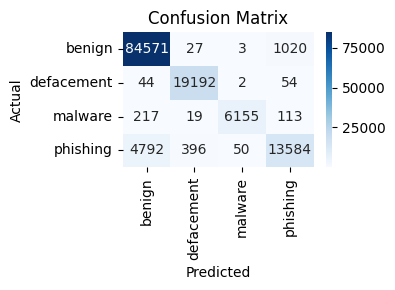


Top tokens pushing toward class: benign
['youtube' 'atwiki' 'otomoto' 'correios' 'himado' 'twitter' 'torrent'
 'htm' 'directory' 'blogspot' 'babal' 'censor' 'paypal' '2015' 'olx']


In [10]:
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")
df   = pd.read_csv(os.path.join(path, "malicious_phish.csv"), on_bad_lines='skip')[['url', 'type']]

# Simple tokenizer
def url_cleanse(u):
    u = u.lower()
    tokens = []
    for part in u.split('/'):
        for chunk in part.replace('-', '.').split('.'):
            if chunk and chunk != 'com':
                tokens.append(chunk)
    return tokens

# Vectorise & split
vec = TfidfVectorizer(tokenizer=url_cleanse, lowercase=False, token_pattern=None)
X   = vec.fit_transform(df['url'])
y   = df['type']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr, ytr)
ypred = clf.predict(Xte)

print("Accuracy:", accuracy_score(yte, ypred))

# Confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(yte, ypred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# Top “malicious” tokens
coefs = clf.coef_[0]  # one-vs-rest: first row = first class (alphabetically)
top_k = 15
top_tokens = np.array(vec.get_feature_names_out())[np.argsort(coefs)[-top_k:]]
print("\nTop tokens pushing toward class:", clf.classes_[0])
print(top_tokens)

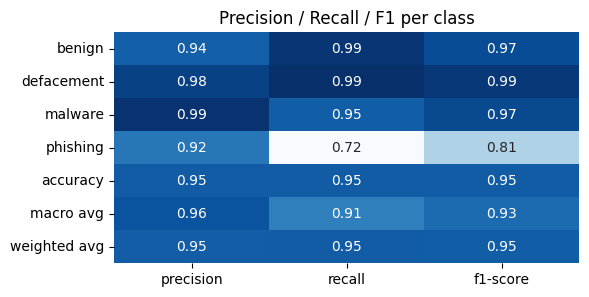

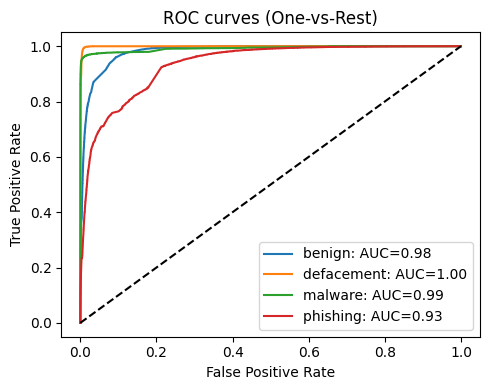

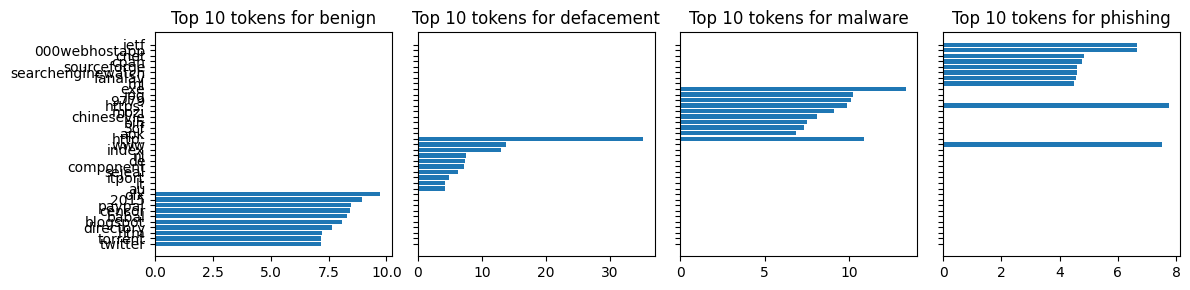

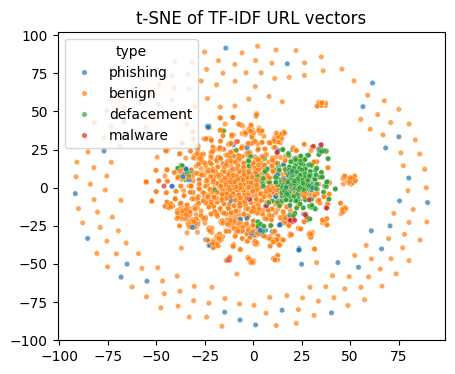

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd


#   Classification report (text + heat-map style)

report = classification_report(yte, ypred, output_dict=True)
plt.figure(figsize=(6,3))
sns.heatmap(pd.DataFrame(report).iloc[:-1,:].T,
            annot=True, cmap="Blues", cbar=False, fmt=".2f")
plt.title("Precision / Recall / F1 per class")
plt.show()

# Per-class ROC curves (One-vs-Rest)

# Binarise labels
classes = np.unique(y)
y_bin   = label_binarize(yte, classes=classes)
y_score = clf.decision_function(Xte)

plt.figure(figsize=(5,4))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{c}: AUC={auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (One-vs-Rest)"); plt.legend(); plt.tight_layout(); plt.show()


# Most “malicious” vs “benign” tokens

feature_names = np.array(vec.get_feature_names_out())
coef = clf.coef_
top = 10
fig, axes = plt.subplots(1, len(classes), figsize=(12,3), sharey=True)
for ax, c, w in zip(axes, classes, coef):
    top_ids = np.argsort(w)[-top:]
    ax.barh(feature_names[top_ids], w[top_ids])
    ax.set_title(f"Top {top} tokens for {c}")
plt.tight_layout(); plt.show()


#  t-SNE 2-D embedding of URL vectors (sample 2 000 for speed)

from sklearn.manifold import TSNE
sample = 2000
X_sample = X[:sample]
y_sample = y[:sample]

tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto")
X_2d = tsne.fit_transform(X_sample)

plt.figure(figsize=(5,4))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y_sample,
                palette="tab10", s=15, alpha=.7)
plt.title("t-SNE of TF-IDF URL vectors"); plt.show()